# 20기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
data = pd.read_csv("/content/drive/MyDrive/대외활동/동아리/투빅스/4주차/blackfriday.csv", index_col=0)
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

([<matplotlib.patches.Wedge at 0x7e0e69e5d510>,
 [Text(-0.785842545718456, 0.7697087068097492, 'M'),
  Text(0.7858425457184559, -0.7697087068097493, 'F')])

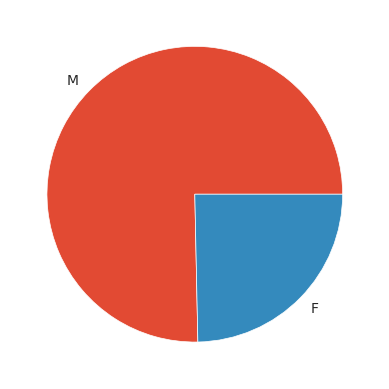

In [24]:
target_label_count = data['Gender'].value_counts()
plt.pie(target_label_count, labels = target_label_count.index)

<Axes: xlabel='Gender', ylabel='Purchase'>

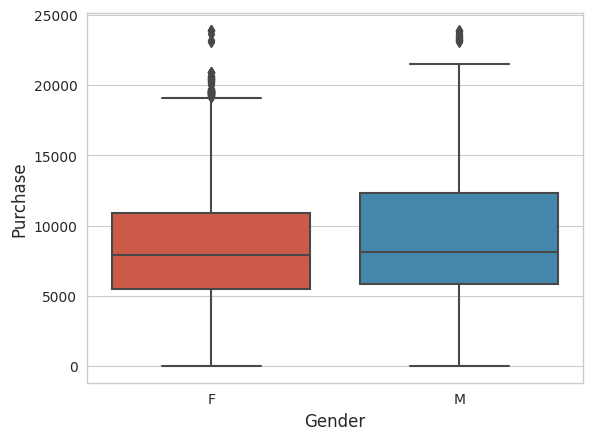

In [25]:
sns.boxplot(x=data['Gender'],y=data['Purchase'])

<Axes: xlabel='Age', ylabel='Purchase'>

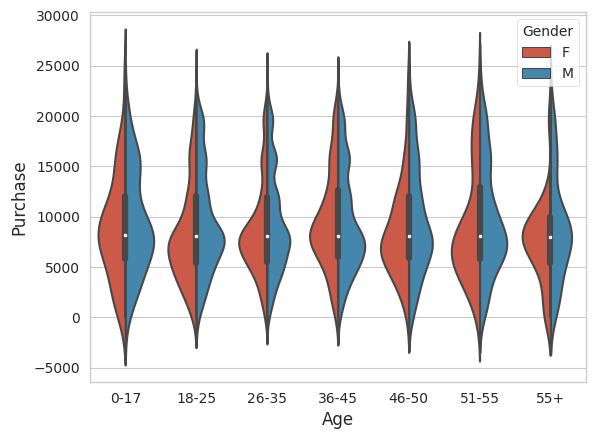

In [26]:
sns.violinplot(x=data['Age'],y=data['Purchase'],hue=data['Gender'],split=True)

<Axes: xlabel='Gender', ylabel='Purchase'>

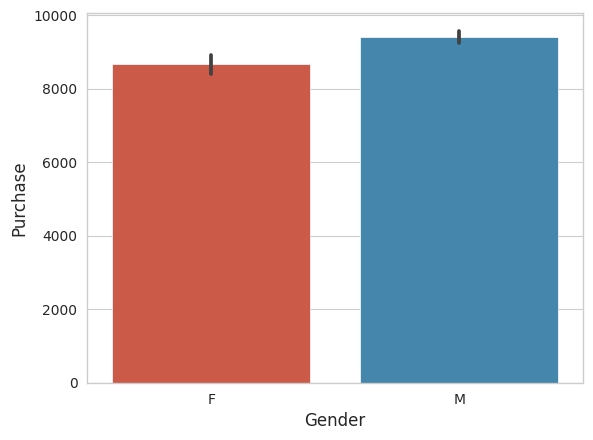

In [27]:
sns.barplot(x=data['Gender'],y=data['Purchase'])

<Axes: >

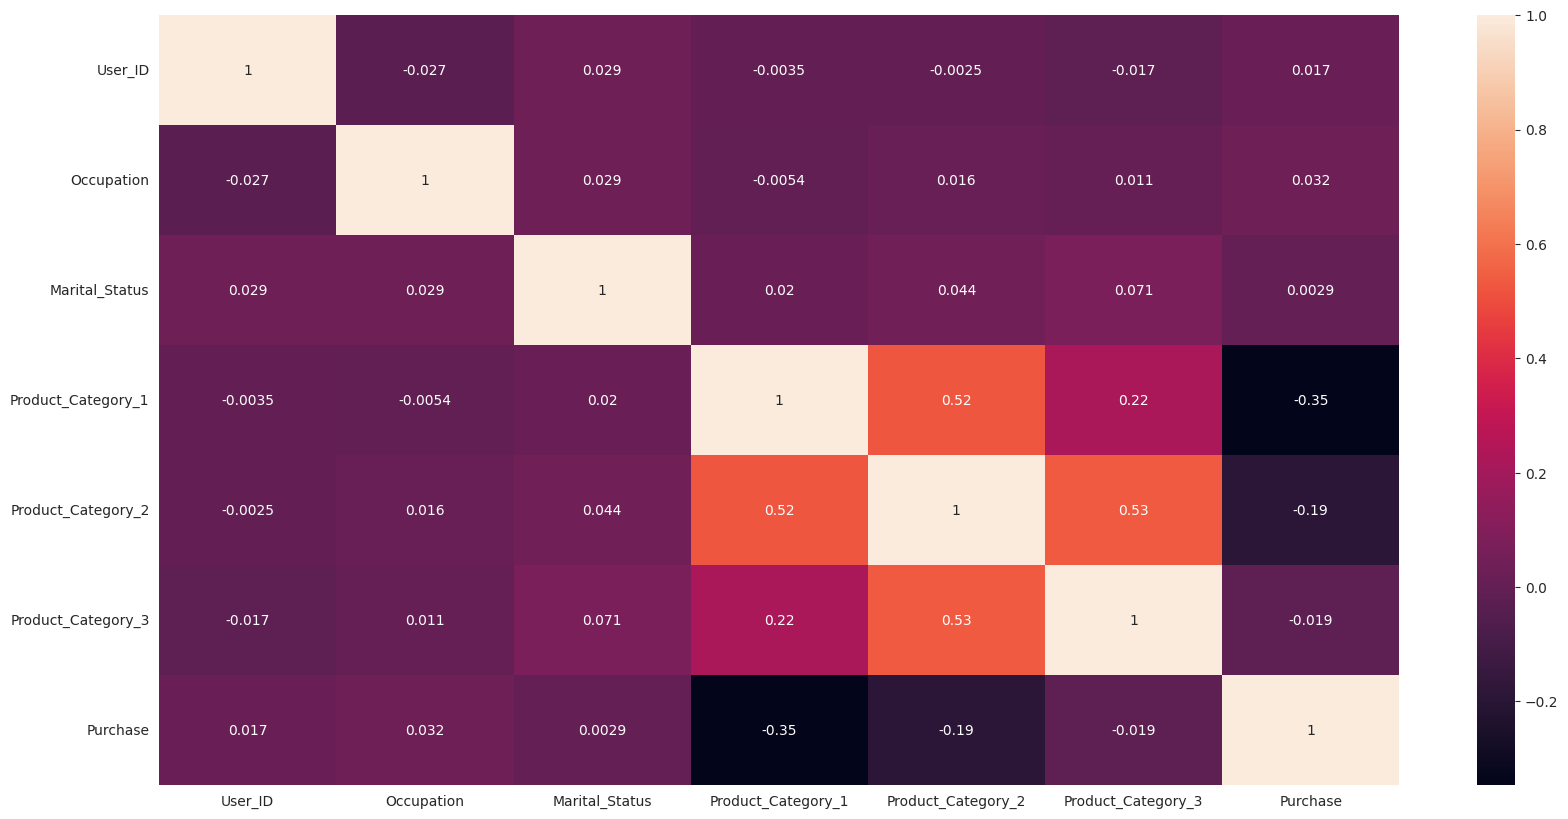

In [28]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot=True)

<Axes: >

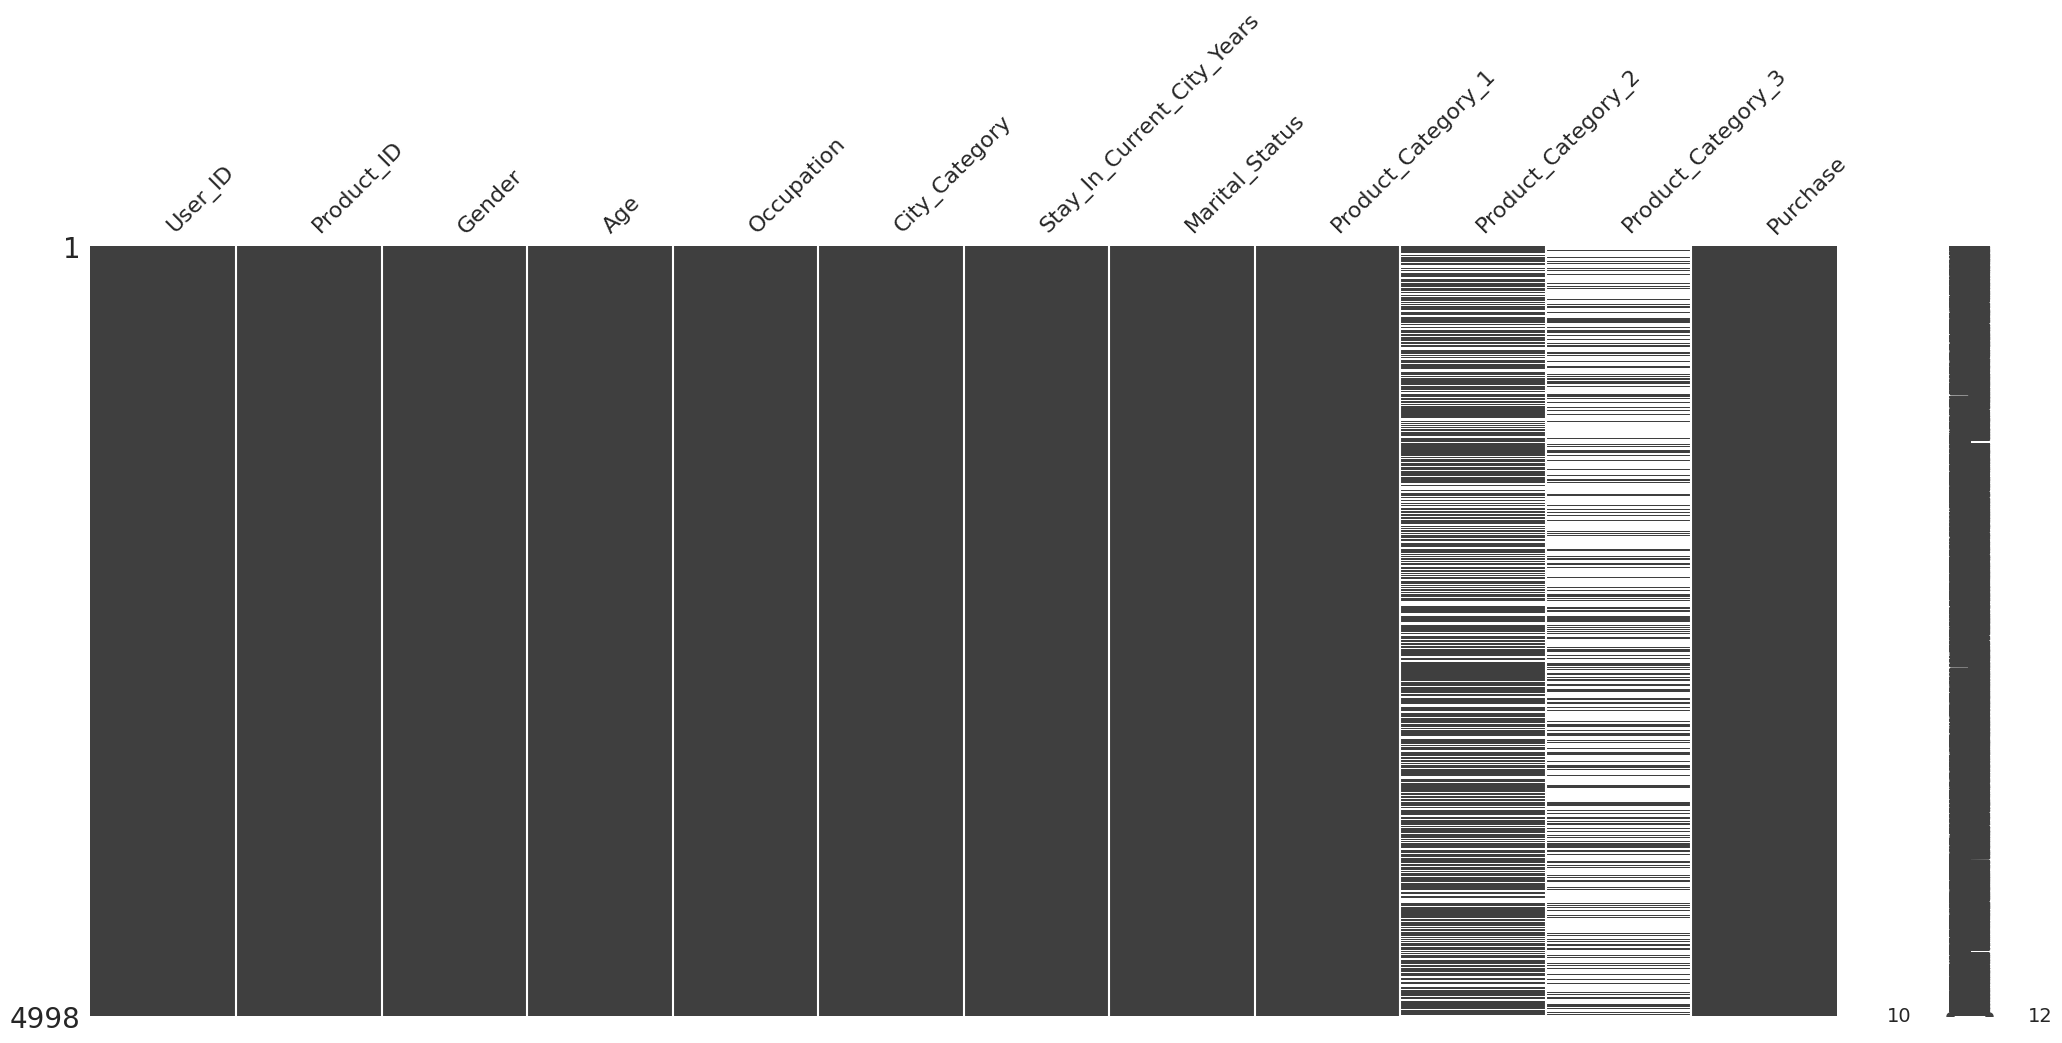

In [29]:
import missingno as msno

msno.matrix(data)

In [30]:
data = data.drop("Product_Category_3", axis=1)
data['Product_Category_2'] = data['Product_Category_2'].fillna(9.)
data['Product_ID'] = data['Product_ID'].map(lambda x:x[:4])

<Axes: xlabel='City_Category', ylabel='count'>

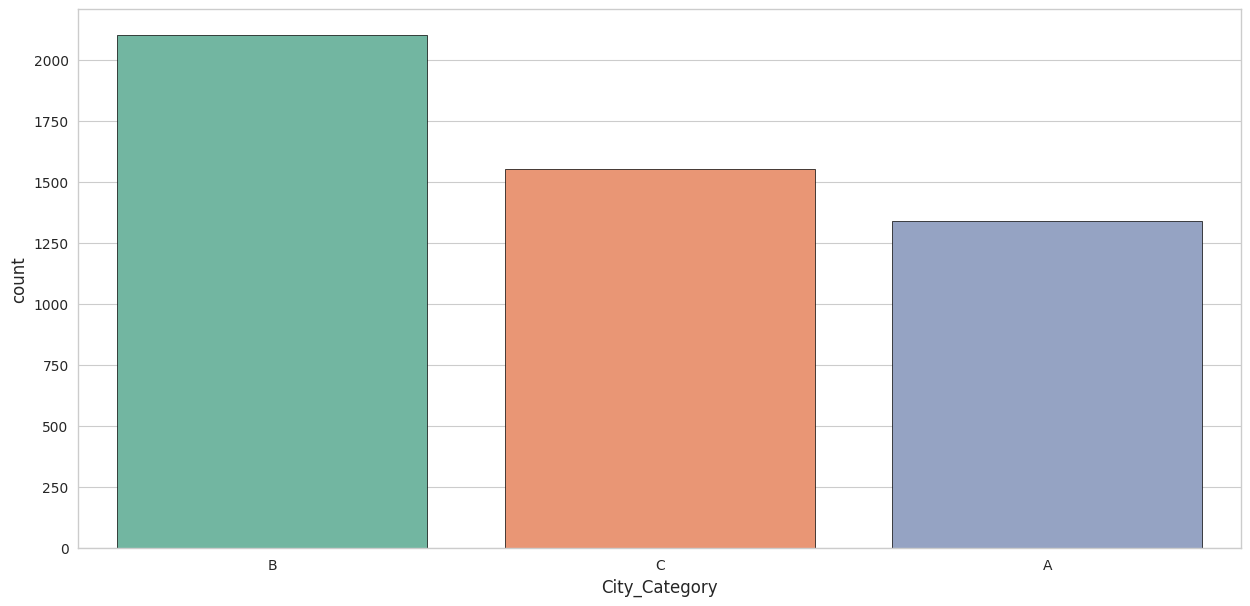

In [31]:

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
col = 'City_Category'
value_counts = data[col].value_counts()
sns.countplot(x=col, data=data, palette='Set2', edgecolor='black', order=value_counts.index)

In [32]:
data = data.drop('User_ID', axis = 1)

y = data['Gender']
X = data.drop("Gender", axis = 1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   shuffle = True,
                                                   random_state = 1015,
                                                   stratify = y)

X_train.reset_index(drop = True, inplace=True)
X_test.reset_index(drop = True, inplace=True)

In [34]:
cat_columns = [c for (c, t) in zip(X.dtypes.index, X.dtypes) if t == 'O']
num_columns = [c for c in X.columns if c not in cat_columns]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in num_columns:
    X_train.loc[:, col] = scaler.fit_transform(np.array(X_train[col]).reshape(-1, 1))
    X_test.loc[:, col] = scaler.transform(np.array(X_test[col]).reshape(-1, 1))

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False)

X_all = pd.concat([X_train, X_test], axis = 0).reset_index(drop=True)

ohe.fit(X_all[cat_columns])

OneHotEncoder(sparse=False, sparse_output=False)

In [35]:
new_X = ohe.transform(X_all[cat_columns])

ohe_columns = ohe.categories_[0].tolist()

for idx in range(len(ohe.categories_)-1):
    ohe_columns += ohe.categories_[idx+1].tolist()

X_cat = pd.DataFrame(new_X, columns = ohe_columns)

In [36]:
X_all.drop(columns=cat_columns, inplace=True)

X = pd.concat([X_all, X_cat], axis = 1)
X_train = X.iloc[:X_train.shape[0], :]
X_test = X.iloc[X_train.shape[0]:, :]

## 2. KNN 구현 & 파라미터 튜닝

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("Test Score : {:.3f}".format(knn.score(X_test, y_test)))

results = knn.predict(X_test)
pd.crosstab(y_test, results, rownames=['Real'], colnames=['Predicted'], margins=True, margins_name='total')


Test Score : 0.722


Predicted,0,1,total
Real,,,
0,48,199,247
1,79,674,753
total,127,873,1000


## 3. Evaluation

In [38]:
from sklearn import metrics
print(metrics.classification_report(y_test,results, digits=2))

              precision    recall  f1-score   support

           0       0.38      0.19      0.26       247
           1       0.77      0.90      0.83       753

    accuracy                           0.72      1000
   macro avg       0.58      0.54      0.54      1000
weighted avg       0.67      0.72      0.69      1000

